# 1. Introduction

This notebook is part of the final project in TDT4173 Machine Learning in practice. The aim of the project is to predict the next positions of vessels at their given timestamps. 

For the task, we were provided with the AIS_train.csv dataset as a mandatory component of the solution, along with three supplementary datasets: ports.csv, schedules_to_may.csv, and vessels.csv. The former set consists 11 features related to the real-time picture of a vessel's position and the latter sets provides more in depth features about the vessels and location of possible ports.

The resulting prediction was uploaded to Kaggle.

This notebook will provide a step by step walkthrough of all data exploration and modifications that has been done to gain the merged dataset. Lastly, it will also cover the models with interpretations.

<b>NB!</b> The installment of Numpy / Pandas below were necessary to run the Numpy and Pandas dependent libraries.

In [1]:
%pip install pandas
%pip install numpy
%pip install threadpoolctl==3.1.0


Note: you may need to restart the kernel to use updated packages.
^C
Traceback (most recent call last):
  File "/Users/minasjovik/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/minasjovik/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/minasjovik/opt/anaconda3/lib/python3.9/site-packages/pip/__main__.py", line 29, in <module>
    from pip._internal.cli.main import main as _main
  File "/Users/minasjovik/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/Users/minasjovik/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/Users/minasjovik/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/main_parser.py", lin

## 1.1 Load data

### 1.1.1 Importing modules

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

### 1.1.2 Open data

In [9]:
# Configure display settings for better output readability
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

train_file_path = '../data/raw/ais_train.csv'
vessels_file_path = '../data/raw/vessels.csv'

# Load the data

train = pd.read_csv(train_file_path, sep='|')
vessels = pd.read_csv(vessels_file_path, sep='|')
train['time'] = pd.to_datetime(train['time'])
train = train.sort_values(by=['vesselId', 'time'])

# Merge vessels data with train data
train = train.merge(vessels, on='vesselId', how='left')

# 2. Exploratory Data Analysis (EDA)

## 1. Understanding the structure of the data

### 2.1.1 AIS train

In [7]:
print("Data Info:")
print(train.info())
print("\nDescriptive Statistics (Numerical Columns):")
print(train.describe())
print("\nDescriptive Statistics (Categorical Columns):")
print(train.describe(include='object'))

Data Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1522065 entries, 131115 to 1522014
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 139.3+ MB
None

Descriptive Statistics (Numerical Columns):
                cog           sog           rot       heading       navstat  \
count  1.522065e+06  1

## 2.2 Individual feature analysis by AIS


In [11]:
print('Number of Training Examples = {}'.format(train.shape[0]))
print('Training X Shape = {}'.format(train.shape))
print('Training y_longitude Shape = {}\n'.format(train['longitude'].shape[0]))
print('Training y_latitude Shape = {}\n'.format(train['latitude'].shape[0]))


Number of Training Examples = 1522065
Training X Shape = (1522065, 30)
Training y_longitude Shape = 1522065

Training y_latitude Shape = 1522065



#### Longitude (target 1)

The box plot indicates that there are a lot of outliers in both the upper and lower region.

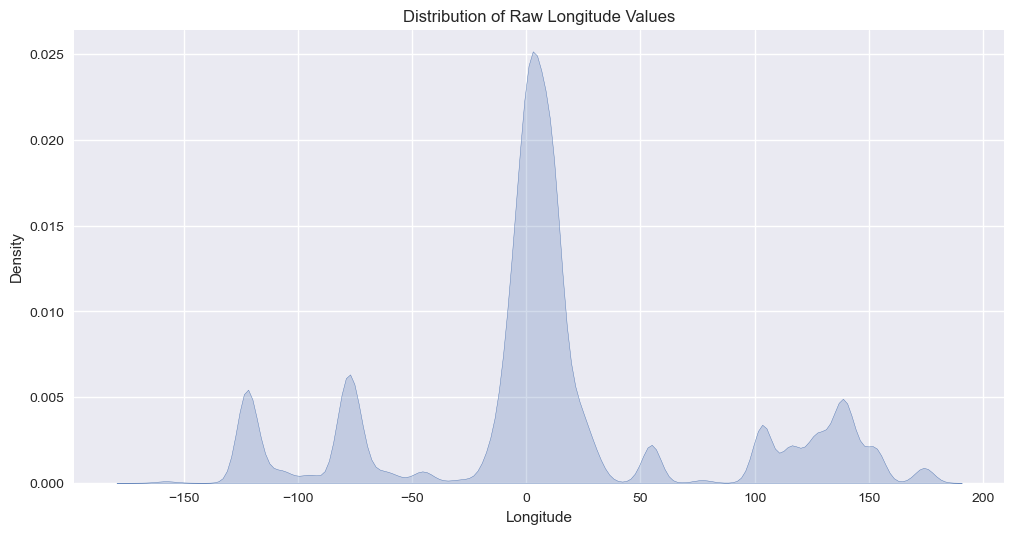

In [19]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

# KDE plot of raw longitude values
sns.kdeplot(train['longitude'].rename('Longitude'), shade=True, ax=ax)
ax.set_title('Distribution of longitude values')
ax.set_xlabel('Longitude')
ax.set_ylabel('Density')

plt.show()

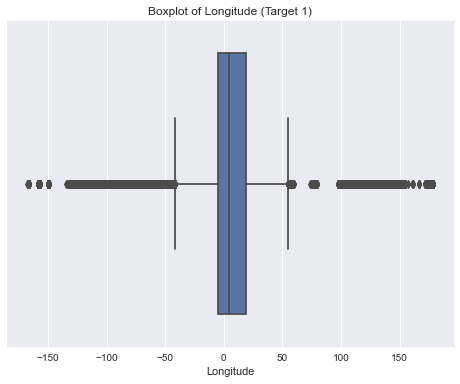

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['longitude'])
plt.title('Boxplot of Longitude')
plt.xlabel('Longitude')
plt.show()

#### Latitude (target 2)

Box plot indicates several outliers in the lower region.

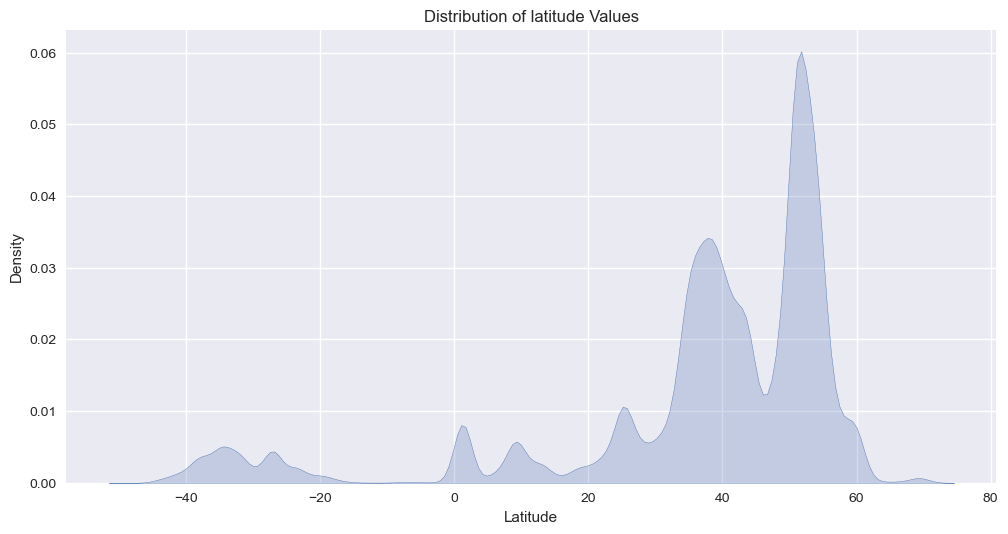

In [21]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)

# KDE plot of raw longitude values
sns.kdeplot(train['latitude'].rename('Latitude'), shade=True, ax=ax)
ax.set_title('Distribution of latitude Values')
ax.set_xlabel('Latitude')
ax.set_ylabel('Density')

plt.show()

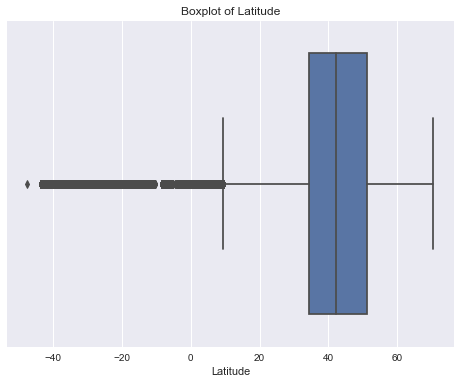

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['latitude'])
plt.title('Boxplot of Latitude')
plt.xlabel('Latitude')
plt.show()

#### Course over Ground (COG)

As per the histogram the COG values seem to have a relatively even distribution across the range. Even though it shows a generally uniform distribution, there are some slight peaks around 0-30 degrees and 240-270 degrees, and some dips around 100-130 and 180 degrees. The lack of spikes or deep gaps can indicate that the COG-values are within the range  of 0 360 degrees, and this is confirmed by the lack of outliers in the box plot.

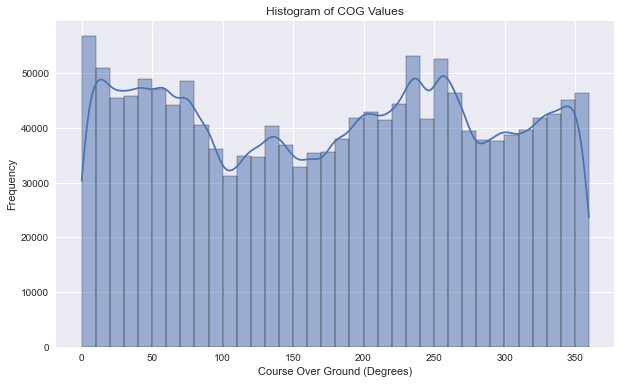

In [26]:
# Filter out invalid COG values (360 and above)
train_filtered = train[(train['cog'] >= 0) & (train['cog'] != 360)]

# 1. Histogram of COG values
plt.figure(figsize=(10, 6))
sns.histplot(train_filtered['cog'], bins=36, kde=True)
plt.title('Histogram of COG Values')
plt.xlabel('Course Over Ground (Degrees)')
plt.ylabel('Frequency')
plt.show()

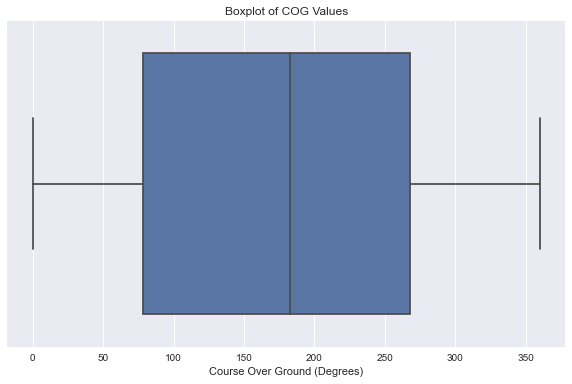

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_filtered['cog'])
plt.title('Boxplot of COG Values')
plt.xlabel('Course Over Ground (Degrees)')
plt.show()

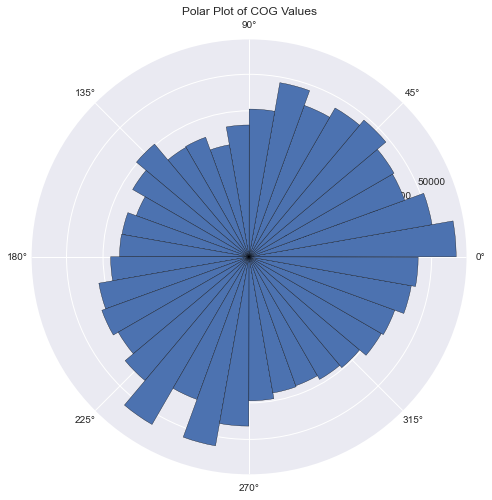

In [28]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
radians = np.deg2rad(train_filtered['cog'])
ax.hist(radians, bins=36, edgecolor='black')
ax.set_title('Polar Plot of COG Values')
plt.show()

#### Speed over Ground (SOG)

We can see that there are some outliers on the right side of the box plot, which indicates that there are some values outside of the accepted range.


In [ ]:
# Distribution plot (KDE) for SOG
plt.figure(figsize=(10, 6))
sns.kdeplot(train['sog'], shade=True)
plt.title('Distribution of Speed Over Ground (SOG)')
plt.xlabel('Speed Over Ground (knots)')
plt.ylabel('Density')
plt.show()

In [ ]:
# Boxplot for SOG
plt.figure(figsize=(10, 6))
sns.boxplot(x=train['sog'])
plt.title('Boxplot of Speed Over Ground (SOG)')
plt.xlabel('Speed Over Ground (knots)')
plt.show()

In [ ]:
# Example: Plotting SOG for a specific vessel (replace 'vessel_id' with an actual vessel ID)
vessel_id = train['vesselId'].iloc[0]  # Use the first vessel ID as an example
vessel_data = train[train['vesselId'] == vessel_id]

plt.figure(figsize=(12, 6))
plt.plot(vessel_data['time'], vessel_data['sog'])
plt.title(f'Time Series of Speed Over Ground (SOG) for Vessel ID {vessel_id}')
plt.xlabel('Time')
plt.ylabel('Speed Over Ground (knots)')
plt.show()

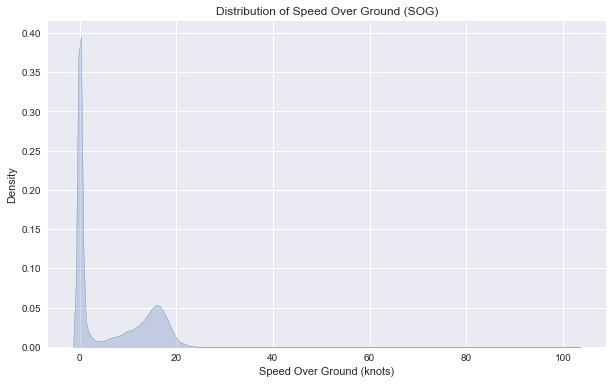

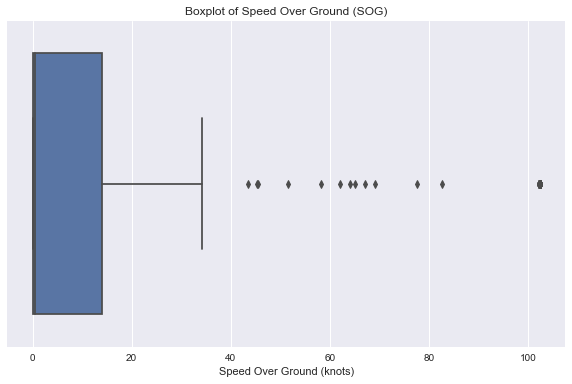

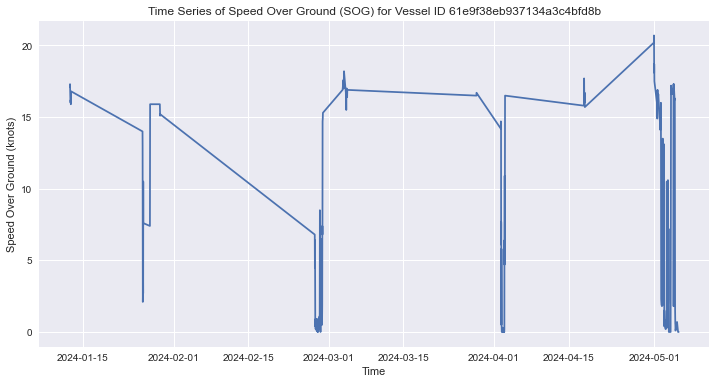

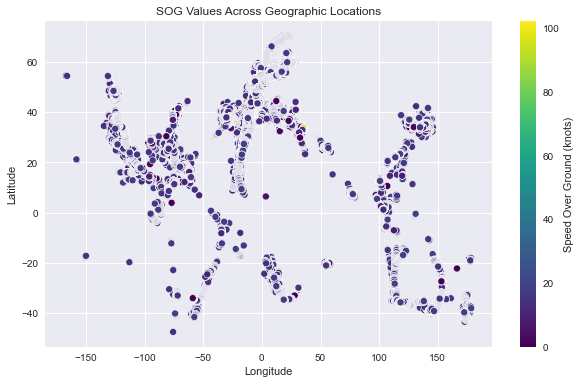

In [32]:
# Scatter plot of SOG vs. Latitude
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x=train['longitude'], 
    y=train['latitude'], 
    hue=train['sog'], 
    palette='viridis',
    legend=False 
)

# Create the colorbar
norm = plt.Normalize(train['sog'].min(), train['sog'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Required for colorbar creation
cbar = plt.colorbar(sm)
cbar.set_label('Speed Over Ground (knots)')

plt.title('SOG Values Across Geographic Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Rate of Turn (ROT)

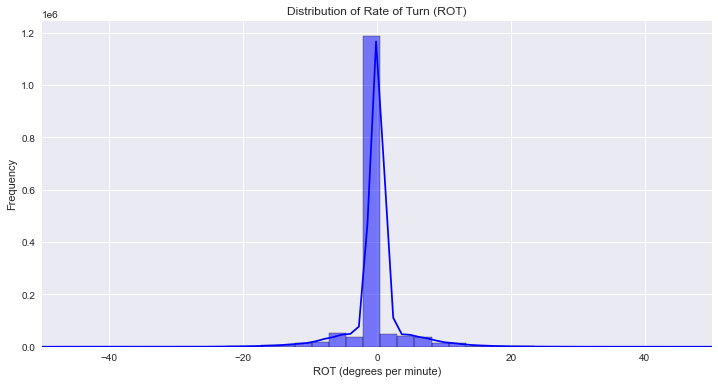

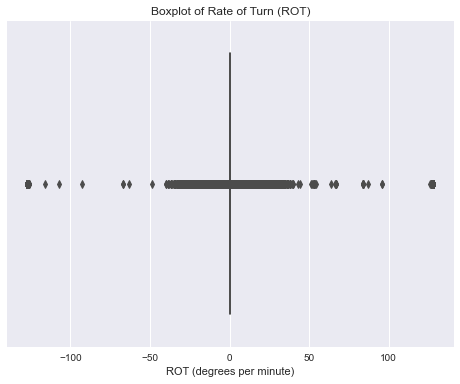

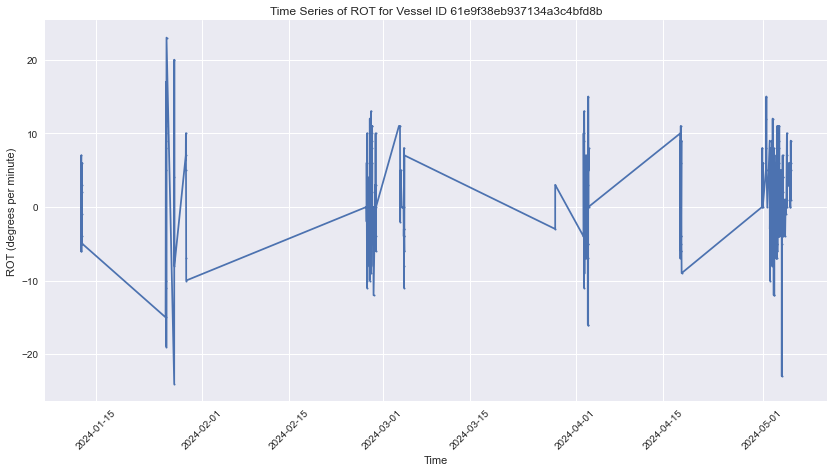

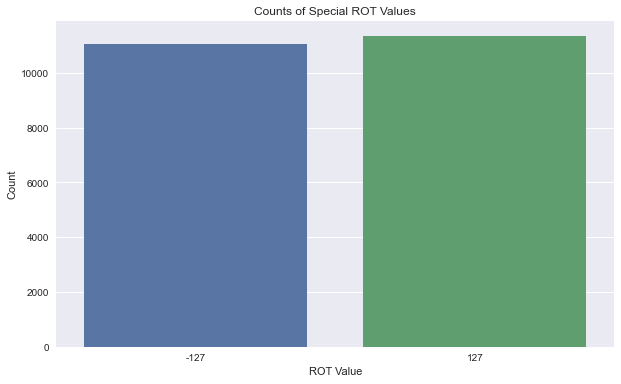

In [37]:
# Plot the distribution of ROT with better visibility
plt.figure(figsize=(12, 6))
sns.histplot(train['rot'], bins=100, kde=True, color='blue', alpha=0.5)  # Adjust bins and transparency (alpha)
plt.xlim(-50, 50)  # Focus on the central range where most data is concentrated
plt.title('Distribution of Rate of Turn (ROT)')
plt.xlabel('ROT (degrees per minute)')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid lines for better readability
plt.show()

# Plot 2: Boxplot of ROT
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['rot'])
plt.title('Boxplot of Rate of Turn (ROT)')
plt.xlabel('ROT (degrees per minute)')
plt.show()

# Plot 3: Time Series Plot of ROT for a Sample Vessel
# Filter data for a specific vessel (replace with an actual vesselId from your data)
sample_vessel_id = train['vesselId'].unique()[0]
vessel_data = train[train['vesselId'] == sample_vessel_id]

plt.figure(figsize=(14, 7))
plt.plot(vessel_data['time'], vessel_data['rot'], marker='o', linestyle='-', markersize=2)
plt.title(f'Time Series of ROT for Vessel ID {sample_vessel_id}')
plt.xlabel('Time')
plt.ylabel('ROT (degrees per minute)')
plt.xticks(rotation=45)
plt.show()

# Plot 4: Bar Plot of Special ROT Values (-127, +127, -128)
special_values = [-128, 127, -127]
special_counts = train[train['rot'].isin(special_values)]['rot'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=special_counts.index, y=special_counts.values)
plt.title('Counts of Special ROT Values')
plt.xlabel('ROT Value')
plt.ylabel('Count')
plt.show()


#### Heading
- As 511 is a value used whenever there are values missing, we see from the cog vs heading plot that there are a lot of values in this range. This indicates the need to remove missing values from the data set.
- There appears to be a faint diagonal trend where COG and HEADING align for certain values. This suggests that in some cases, the vessel's course over ground matches its heading, which makes sense when vessels are moving directly in the direction they are pointing.


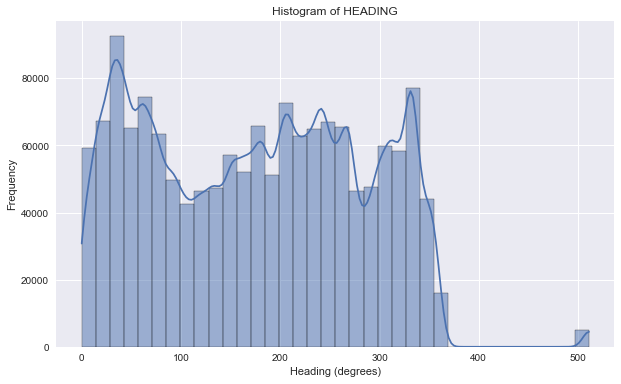

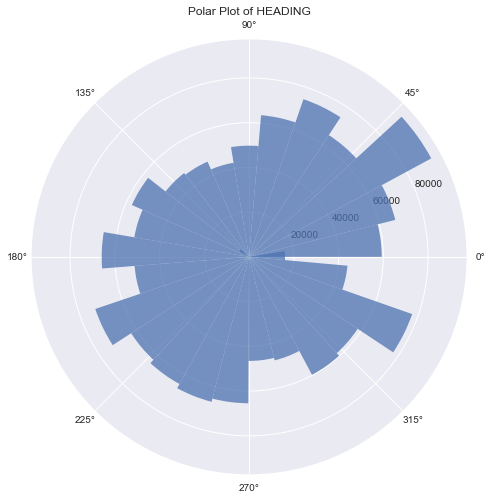

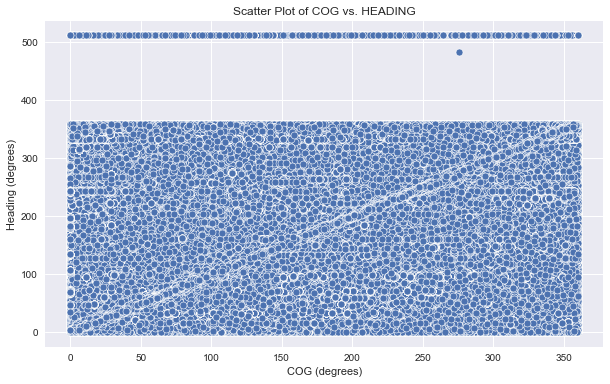

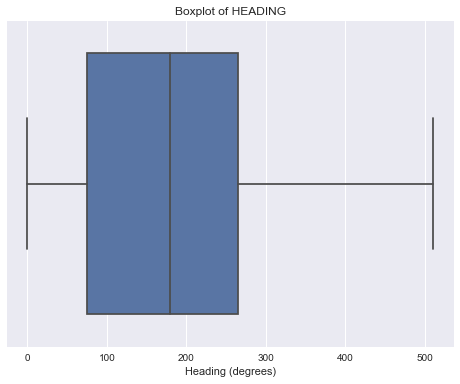

In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(train['heading'], bins=36, kde=True)
plt.title('Histogram of HEADING')
plt.xlabel('Heading (degrees)')
plt.ylabel('Frequency')
plt.show()

# 2. Polar Plot of HEADING
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)
# Convert heading degrees to radians for the polar plot
headings_radians = np.deg2rad(train['heading'])
ax.hist(headings_radians, bins=36, alpha=0.75)
ax.set_title('Polar Plot of HEADING')
plt.show()

# 3. Scatter Plot of HEADING vs. COG
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['cog'], y=train['heading'])
plt.title('Scatter Plot of COG vs. HEADING')
plt.xlabel('COG (degrees)')
plt.ylabel('Heading (degrees)')
plt.show()

# 4. Boxplot of HEADING
plt.figure(figsize=(8, 6))
sns.boxplot(x=train['heading'])
plt.title('Boxplot of HEADING')
plt.xlabel('Heading (degrees)')
plt.show()

Index(['time', 'cog', 'sog', 'rot', 'heading', 'navstat', 'etaRaw', 'latitude',
       'longitude', 'vesselId', 'portId', 'shippingLineId', 'CEU', 'DWT', 'GT',
       'NT', 'vesselType', 'breadth', 'depth', 'draft', 'enginePower',
       'freshWater', 'fuel', 'homePort', 'length', 'maxHeight', 'maxSpeed',
       'maxWidth', 'rampCapacity', 'yearBuilt', 'longitude_standardized',
       'longitude_normalized', 'cog_heading_divergence'],
      dtype='object')


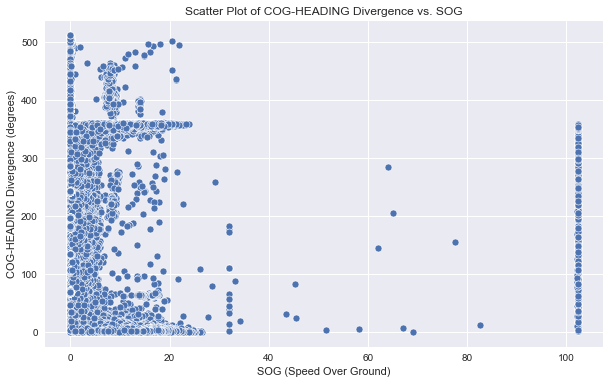

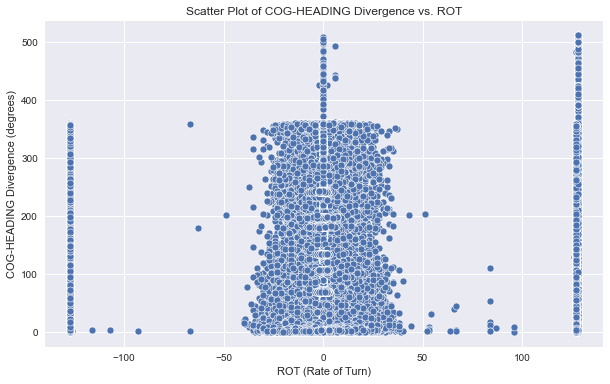

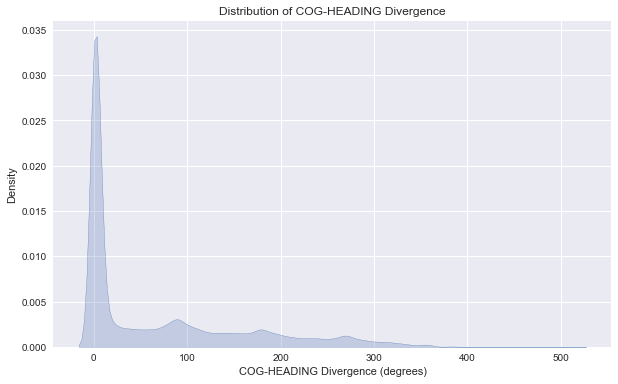

In [40]:
# Calculate the discrepancy between COG and HEADING
train['cog_heading_divergence'] = np.abs(train['cog'] - train['heading'])
print(train.columns)

# Scatter plot of COG-HEADING divergence vs. SOG
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['sog'], y=train['cog_heading_divergence'])
plt.title('Scatter Plot of COG-HEADING Divergence vs. SOG')
plt.xlabel('SOG (Speed Over Ground)')
plt.ylabel('COG-HEADING Divergence (degrees)')
plt.show()

# Scatter plot of COG-HEADING divergence vs. ROT
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train['rot'], y=train['cog_heading_divergence'])
plt.title('Scatter Plot of COG-HEADING Divergence vs. ROT')
plt.xlabel('ROT (Rate of Turn)')
plt.ylabel('COG-HEADING Divergence (degrees)')
plt.show()

# KDE plot to visualize the distribution of the divergence
plt.figure(figsize=(10, 6))
sns.kdeplot(train['cog_heading_divergence'], shade=True)
plt.title('Distribution of COG-HEADING Divergence')
plt.xlabel('COG-HEADING Divergence (degrees)')
plt.ylabel('Density')
plt.show()


- The plot shows that the divergence between COG and HEADING is generally concentrated at lower speeds (SOG < 20 knots). Which indicates that most of the vessels with significant divergence are moving slowly or are stationary.

- The scatter plot shows that the COG-HEADING divergence tends to be higher when the ROT is close to zero. This suggests that even when the vessel is not turning, there is still divergence, possibly due to drift or external factors like currents. But is also shows that they are not that closely related to each other.

#### NAVSTAT

- We see that the most frequent states are 0 and 5, and also 1 at lower frequency. The dominance of only a few states indicates stable behavior in the vessels.
- The stable time series plot indicates that over time there are no big changes in the state of the vessel.

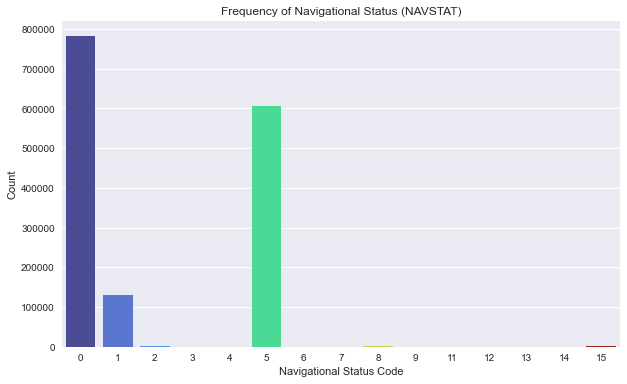

<Figure size 864x576 with 0 Axes>

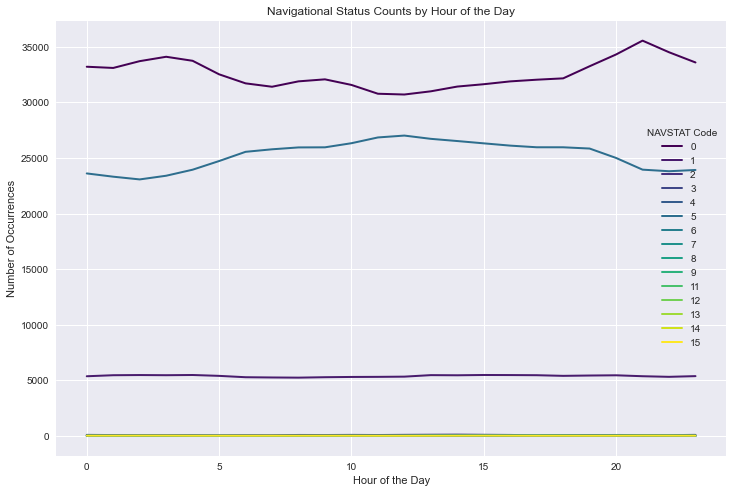

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot of NAVSTAT frequencies
plt.figure(figsize=(10, 6))
sns.countplot(x='navstat', data=train, palette='turbo')
plt.title('Frequency of Navigational Status (NAVSTAT)')
plt.xlabel('Navigational Status Code')
plt.ylabel('Count')
plt.show()

# Group by time period (e.g., hour) to count NAVSTAT occurrences
time_navstat = train.groupby([train['time'].dt.hour, 'navstat']).size().unstack()

# Plot the time series for NAVSTAT counts per hour
plt.figure(figsize=(12, 8))
time_navstat.plot(kind='line', linewidth=2, colormap='viridis', figsize=(12, 8))
plt.title('Navigational Status Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Occurrences')
plt.legend(title='NAVSTAT Code')
plt.show()


#### Estimated Time of Arrival RAW (ETARAW)
- From these plots it is clear that most of the arrivals are scheduled to the first months of the year and around the early morning or late evening hours.
- Unsure if this feature is of any relevance for our task?

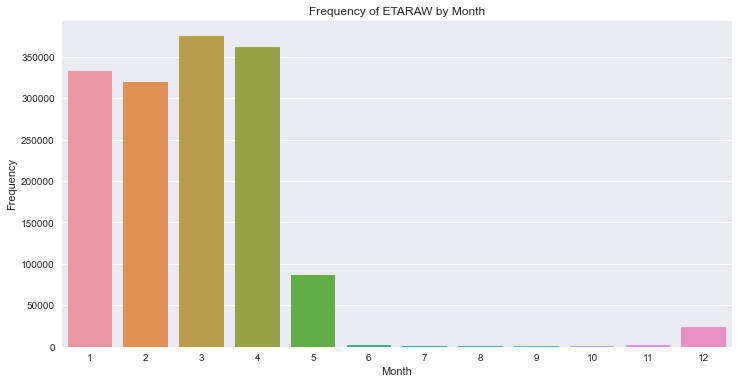

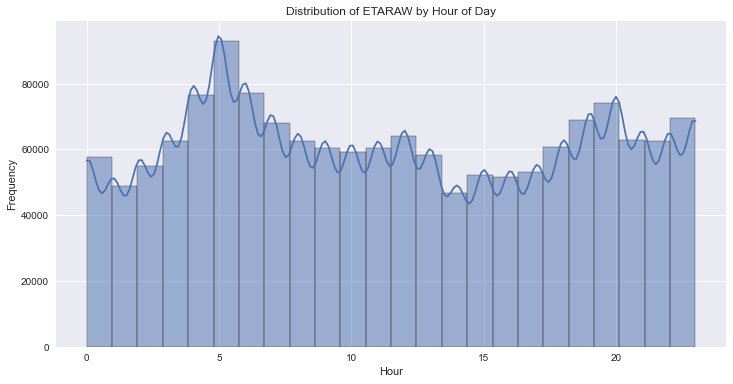

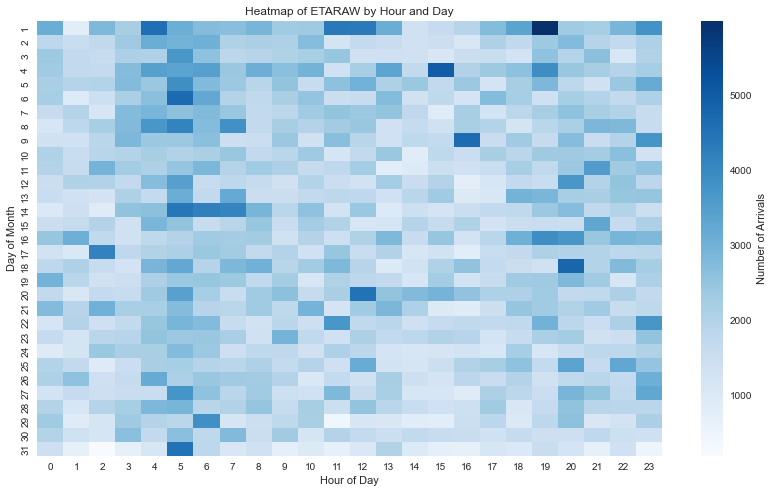

In [52]:
# Parse 'ETARAW' into month, day, and hour components
train['eta_parsed'] = pd.to_datetime(train['etaRaw'], errors='coerce', format='%m-%d %H:%M')
train = train.dropna(subset=['eta_parsed'])
train['eta_month'] = train['eta_parsed'].dt.month
train['eta_hour'] = train['eta_parsed'].dt.hour
train['eta_day'] = train['eta_parsed'].dt.day


# 1. ETARAW Distribution by Month
plt.figure(figsize=(12, 6))
sns.countplot(x='eta_month', data=train)
plt.title('Frequency of ETARAW by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.show()

# 2. Hour of Day Analysis
plt.figure(figsize=(12, 6))
sns.histplot(train['eta_hour'].dropna(), bins=24, kde=True)
plt.title('Distribution of ETARAW by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

# 3. Heatmap of ETARAW by Hour and Day
hour_day_pivot = train.pivot_table(index='eta_day', columns='eta_hour', aggfunc='size', fill_value=0)
plt.figure(figsize=(14, 8))
sns.heatmap(hour_day_pivot, cmap='Blues', cbar_kws={'label': 'Number of Arrivals'})
plt.title('Heatmap of ETARAW by Hour and Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Month')
plt.show()


#### Care Equivalent Unit (CEU)

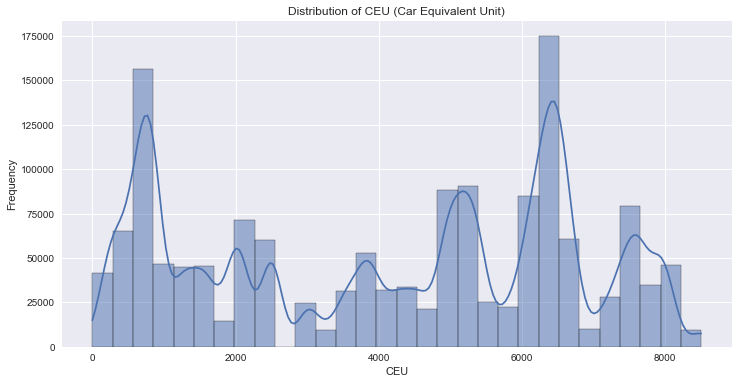

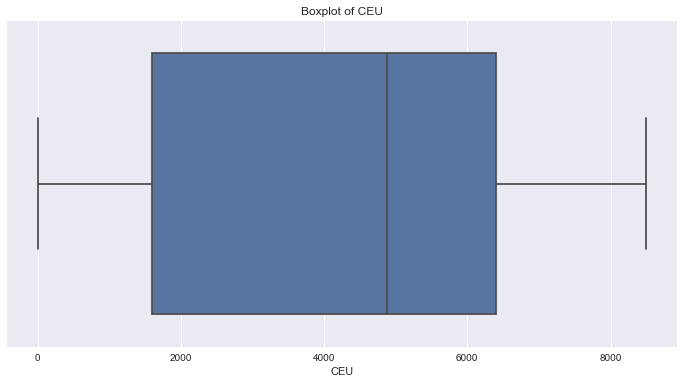

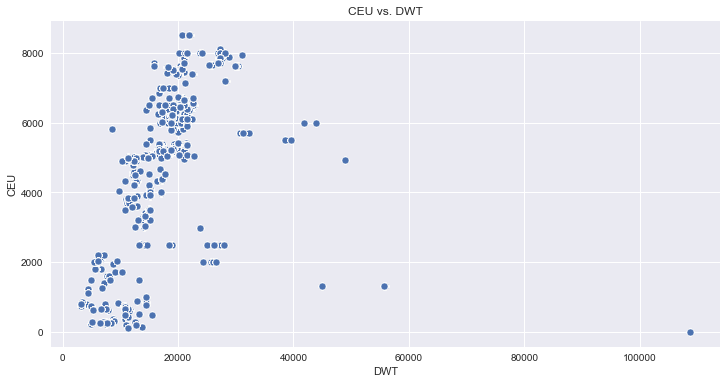

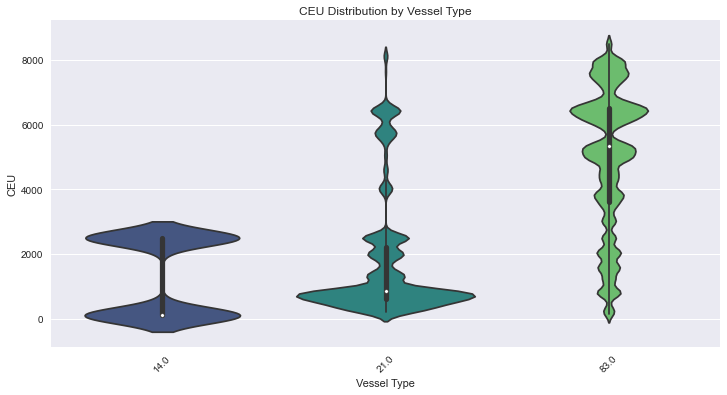

In [54]:
# Distribution plot (Histogram and KDE) for CEU
plt.figure(figsize=(12, 6))
sns.histplot(train['CEU'], bins=30, kde=True)
plt.title('Distribution of CEU')
plt.xlabel('CEU')
plt.ylabel('Frequency')
plt.show()

# Boxplot for CEU to identify outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=train['CEU'])
plt.title('Boxplot of CEU')
plt.xlabel('CEU')
plt.show()

# Scatter plot of CEU vs. DWT (Deadweight Tonnage)
plt.figure(figsize=(12, 6))
sns.scatterplot(x=train['DWT'], y=train['CEU'])
plt.title('CEU vs. DWT')
plt.xlabel('DWT')
plt.ylabel('CEU')
plt.show()

# Violin plot to compare CEU distribution by vessel type
plt.figure(figsize=(12, 6))
sns.violinplot(x=train['vesselType'], y=train['CEU'], palette='viridis')
plt.title('CEU Distribution by Vessel Type')
plt.xlabel('Vessel Type')
plt.ylabel('CEU')
plt.xticks(rotation=45)
plt.show()


#### Checking uniqueness in cathegorical variables 

In [ ]:
categorical_cols = ['vesselType', 'homePort']
for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(train[col].unique())

### Correlation analysis


In [ ]:
plt.figure(figsize=(12, 8))
corr = train.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("correlation heatmap")
plt.show()

- From the correlation heat map we can see that some vessel features are significantly correlated to others, like "yearBuilt" and "vessel_age". Need to explore if these it is possible to create interacting terms or scale them. 

- Given that some features show high correlations (e.g., CEU, DWT, and other tonnage-related variables), we need to explore clustering analysis to see if vessels can be grouped into different categories based on these.

- Need to look into maxSpeed, enginePower etc as they have high variability which might indicate outliers


#### Understanding the distribution of cathegorical features

In [ ]:
plt.figure(figsize=(12, 6))
train['vesselType'].value_counts().plot(kind='bar')
plt.title('Distribution of Vessel Types')
plt.xlabel('Vessel Type')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 6))
train['homePort'].value_counts().plot(kind='bar')
plt.title('Distribution of Home Ports')
plt.xlabel('Home Port')
plt.ylabel('Count')
plt.show()

### Checking for multicollinearity using Variance Inflation Factor (VIF)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select numeric columns
numeric_columns = train.select_dtypes(include=[np.number]).columns.tolist()
X = train[numeric_columns]

# Fill missing values with column means
X_filled = X.fillna(X.mean())

# Remove columns with zero variance
X_filled = X_filled.loc[:, X_filled.var() != 0]

# Check for highly correlated features (threshold set to 0.95)
correlation_matrix = X_filled.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

# Drop these columns from X_filled
X_filtered = X_filled.drop(columns=to_drop)

# Calculate VIF for each feature in the filtered dataset
vif_data = pd.DataFrame()
vif_data['Feature'] = X_filtered.columns
vif_data['VIF'] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

# Display the VIF data
vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False)
print(vif_data_sorted)




#### Vizualising highly correlated features

In [ ]:
# Select highly correlated features
high_corr_features = ['DWT', 'GT', 'length', 'breadth', 'yearBuilt']

# Visualize pairwise relationships
sns.pairplot(train[high_corr_features])
plt.show()


### Clustering and K-means

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:


# Check for missing values in 'DWT' and 'CEU' columns
if train['DWT'].isnull().sum() > 0 or train['CEU'].isnull().sum() > 0 or train['GT'].isnull().sum() > 0 or train['NT'].isnull().sum() > 0:
    # Handle missing values (e.g., by filling with the median value of each column)
    train['DWT'].fillna(train['DWT'].median(), inplace=True)
    train['CEU'].fillna(train['CEU'].median(), inplace=True)
    train['GT'].fillna(train['GT'].median(), inplace=True)
    train['NT'].fillna(train['NT'].median(), inplace=True)
    
# Extract the features for clustering
X = train[['DWT', 'CEU', 'GT', 'NT']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)

# Determine the optimal number of clusters using the elbow method
inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Apply K-means clustering with the chosen number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
train['Cluster'] = kmeans.fit_predict(X_scaled)

# View the DataFrame with the cluster labels
print(train.head())


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Pair plot to visualize clusters
sns.pairplot(train, vars=['DWT', 'CEU', 'GT', 'NT'], hue='Cluster', palette='viridis')
plt.suptitle('Pair Plot of Clusters', y=1.02)
plt.show()

# 3D scatter plot of the clusters (using 'DWT', 'GT', and 'NT')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train['DWT'], train['GT'], train['NT'], c=train['Cluster'], cmap='viridis', s=50)

# Set labels and title
ax.set_xlabel('DWT')
ax.set_ylabel('GT')
ax.set_zlabel('NT')
ax.set_title('3D Scatter Plot of Clusters')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
ax.add_artist(legend1)

plt.show()


#### Outlier detection

In [ ]:
# Features to check for outliers
outlier_features = ['maxSpeed', 'enginePower', 'DWT']

# Plot boxplots for the selected features
for feature in outlier_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=train[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

#### Removing outliers in the data

In [ ]:
from scipy import stats

def remove_outliers(df, features, threshold=3):
    """
    Removes outliers based on the Z-score method for the specified features.
    Outliers are defined as values where the Z-score is greater than the threshold.
    """
    df_clean = df.copy()
    for feature in features:
        z_scores = np.abs(stats.zscore(df_clean[feature]))
        df_clean = df_clean[z_scores < threshold]
        print(f"Removed outliers from {feature}. Remaining rows: {df_clean.shape[0]}")
    return df_clean

# Apply the function to remove outliers from the dataset
train_cleaned = remove_outliers(train, outlier_features)

# 2. Exploratory Data Analysis (EDA)

## 2.1 Understanding data features

In [ ]:
train['vessel_age'] = train['time'].dt.year - train['yearBuilt']
print("\nVessel Age Summary Statistics:")
print(train['vessel_age'].describe())

plt.figure(figsize=(12, 6))
train['vessel_age'].plot(kind='hist', bins=30)
plt.title('Vessel Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='vesselType', y='GT', data=train)
plt.title('Vessel Type vs. Gross Tonnage')
plt.xlabel('Vessel Type')
plt.ylabel('Gross Tonnage (GT)')
plt.xticks(rotation=45)
plt.show()